<a href="https://colab.research.google.com/github/maoya23/hobby/blob/main/BaseBall_PoseEstimation_Yolo_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Google driveの読み込み

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd ./drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


## 2. Yoloのインストール

In [152]:
try:
  from ultralytics import YOLO
except:
  %pip install ultralytics >& /dev/null
  from ultralytics import YOLO
import cv2
import csv
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

## 3. Yoloのモデル選択
- 使いたいモデルのコメントを外す。下に行くほど実行に時間がかかる

In [3]:
model=YOLO(
    #'yolov8n-pose.pt'
    'yolov8s-pose.pt'
    #'yolov8m-pose.pt'
    #'yolov8l-pose.pt'
    #'yolov8x-pose.pt'
    #'yolov8x-pose-p6.pt'
)

In [43]:
class CFG:
  video_name='swing_latest'
  root_path='/content/drive/MyDrive/dataset/'
  input_video_path=f'{root_path}{video_name}/InputVideo.mp4'
  output_video_path=f'{root_path}{video_name}/OutputVideo.mp4'
  csv_path=f'{root_path}{video_name}/Output.csv'

  KEYPOINTS_NAMES=[
    'nose',
    'eye(L)','eye(R)','ear(L)','ear(R)',
    'shoulder(L)','shoulder(R)','elbow(L)','elbow(R)',
    'wrist(L)','wrist(R)','hip(L)','hip(R)',
    'knee(L)','knee(R)','ankle(L)','ankle(R)'
    ]

  connections = [
      ('nose', 'eye(L)'), ('nose', 'eye(R)'), ('eye(L)', 'ear(L)'), ('eye(R)', 'ear(R)'),
      ('nose', 'shoulder(L)'), ('nose', 'shoulder(R)'), ('shoulder(L)', 'elbow(L)'),
      ('shoulder(R)', 'elbow(R)'), ('elbow(L)', 'wrist(L)'), ('elbow(R)', 'wrist(R)'),
      ('shoulder(L)', 'shoulder(R)'), ('shoulder(L)', 'hip(L)'), ('shoulder(R)', 'hip(R)'),
      ('hip(L)', 'hip(R)'), ('hip(L)', 'knee(L)'), ('hip(R)', 'knee(R)'),
      ('knee(L)', 'ankle(L)'), ('knee(R)', 'ankle(R)')
    ]

  keypoints = {
      'nose': 0, 'eye(L)': 1, 'eye(R)': 2, 'ear(L)': 3, 'ear(R)': 4,
      'shoulder(L)': 5, 'shoulder(R)': 6, 'elbow(L)': 7, 'elbow(R)': 8,
      'wrist(L)': 9, 'wrist(R)': 10, 'hip(L)': 11, 'hip(R)': 12,
      'knee(L)': 13, 'knee(R)': 14, 'ankle(L)': 15, 'ankle(R)': 16
  }


cfg=CFG()

cfg.keypoints['nose']

0

## 4. ディレクトリの作成

In [5]:
os.makedirs(cfg.root_path,exist_ok=True)
os.makedirs(f'{cfg.root_path}{cfg.video_name}',exist_ok=True)

## 5.動画の時間の調整

In [6]:
%%time
if not os.path.exists(f'{cfg.input_video_path}_cut.mp4'):
  !ffmpeg -ss 00:07 -i {cfg.input_video_path} -to 00:11 -c copy {cfg.input_video_path}_cut.mp4
  !ffmpeg -y -i {cfg.input_video_path}_cut.mp4 -vf "fps=30" {cfg.input_video_path}_fp30.mp4
else:
  pass

CPU times: user 1.82 ms, sys: 0 ns, total: 1.82 ms
Wall time: 244 ms


In [7]:
### 動画を再生して確認する
from IPython.display import HTML
from base64 import b64encode

mp4 = open( f'{cfg.input_video_path}_fp30.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="50%" height="50%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

## 6.モデルの関数の定義

In [8]:
def setup_video_writer(capture,output_path):
  fourcc=cv2.VideoWriter_fourcc(*'mp4v')
  fps=capture.get(cv2.CAP_PROP_FPS)
  width=int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
  height=int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
  return cv2.VideoWriter(output_path, fourcc, fps, (width, height))

In [9]:
def write_pose2csv(csv_path,frame_count,keypoints,confs):
  row=[frame_count]
  for index,keypoint in enumerate(zip(keypoints,confs)):
    x,y=int(keypoint[0][0]),int(keypoint[0][1])
    score=keypoint[1]
    row.extend([x,y,score])
  with open(csv_path,mode='a',newline='') as file:
    writer = csv.writer(file)
    writer.writerow(row)

In [103]:
def draw_keypoints(frame, keypoints, confs):
    """フレームにキーポイントと骨格を描画する"""
    coords=[]#座標を格納するリストを先に作っておく

    for index, keypoint in enumerate(zip(keypoints, confs)):
        x, y = int(keypoint[0][0]) ,int(keypoint[0][1])
        score = keypoint[1]
        #print(f'{cfg.KEYPOINTS_NAMES[index]}のkeypointの座標とスコアは{keypoint}')
        if score >= 0.5:
            cv2.circle(frame, (x, y), 5, (255, 0, 255), -1)
            cv2.putText(frame, cfg.KEYPOINTS_NAMES[index], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1, cv2.LINE_AA)
        coords.append((x,y))#keypointの順番にx座標とy座標をタプル型で追加していく
    #print(coords)

    #for connection in cfg.connections:
    for i, connection in enumerate(cfg.connections):
      if i not in [0, 1, 2, 3 ,4 ,5]:#耳は推定しにくいから外したいのでconnectionの中で鼻より上の接続は省く
      #print(connection)
        nodeA , nodeB = cfg.keypoints[connection[0]] , cfg.keypoints[connection[1]]#keypointsの引数に文字を指定することで返り値がキーポイントに割り当てられている整数になる
        cv2.line(frame, coords[nodeA], coords[nodeB], (0, 255, 0), 2)
    return frame

### Appendix : 備忘録も兼ねてkeypointの構造を記しておく。

keypointは  keypoints = {
      'nose': 0, 'eye(L)': 1, 'eye(R)': 2, 'ear(L)': 3, 'ear(R)': 4,
      'shoulder(L)': 5, 'shoulder(R)': 6, 'elbow(L)': 7, 'elbow(R)': 8,
      'wrist(L)': 9, 'wrist(R)': 10, 'hip(L)': 11, 'hip(R)': 12,
      'knee(L)': 13, 'knee(R)': 14, 'ankle(L)': 15, 'ankle(R)': 16
  }

  の順番で値が保存されていて、それぞれのキーポイントに対して[(xの座標 , yの座標) , スコア（信頼度）]の値が保存されている。

In [104]:
# 8 動画をフレームごとに処理し、姿勢情報を取得してCSVと動画に保存する
def process_video(input_video_path, output_video_path, csv_path):
    """動画をフレームごとに処理し、姿勢情報を取得してCSVと動画に保存する"""
    capture = cv2.VideoCapture(input_video_path)
    video_writer = setup_video_writer(capture, output_video_path)

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        # ヘッダー行を書き込む
        header = ["frame"]
        for name in cfg.KEYPOINTS_NAMES:
            header.extend([f"{name}_x", f"{name}_y", f"{name}_score"])
        writer.writerow(header)

    frame_count = 0

    while capture.isOpened():
        success, frame = capture.read()
        if not success:
            break

        # 推論を実行
        results = model(frame)

        if results[0].keypoints.conf!=None: #フレームにキーポイントがない場合は推論を実行しない
          if len(results[0].keypoints) > 0:
              keypoints = results[0].keypoints

              confs = keypoints.conf[0].tolist()  # 推論結果:1に近いほど信頼度が高い
              xys = keypoints.xy[0].tolist()  # 座標

              # 姿勢情報をCSVファイルに書き出す
              write_pose2csv(csv_path, frame_count, xys, confs)
              # キーポイントと骨格をフレームに描画する
              frame = draw_keypoints(frame, xys, confs)


        # フレームに骨格情報を描画したものを動画に書き出す
        video_writer.write(frame)
        frame_count += 1

    capture.release()
    video_writer.release()
    cv2.destroyAllWindows()

## 7.推論の実行

In [105]:
%%time
process_video(f'{cfg.input_video_path}_fp30.mp4', cfg.output_video_path, cfg.csv_path)


0: 640x384 1 person, 441.0ms
Speed: 4.6ms preprocess, 441.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 453.1ms
Speed: 5.1ms preprocess, 453.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 451.0ms
Speed: 5.1ms preprocess, 451.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 451.9ms
Speed: 4.1ms preprocess, 451.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 459.3ms
Speed: 5.3ms preprocess, 459.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 453.7ms
Speed: 4.1ms preprocess, 453.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 477.0ms
Speed: 4.9ms preprocess, 477.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 453.7ms
Speed: 5.3ms preprocess, 453.7ms inference, 1.1ms postprocess per image at

In [106]:
!ffmpeg -y -i {cfg.output_video_path} -vf scale=600:-2 {cfg.root_path}{cfg.video_name}_fps30with_pose.mov

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

## 8. 姿勢推定した線を乗せた動画を再生する

In [107]:
### Y05.6 動画の再生
from IPython.display import HTML
from base64 import b64encode

mp4 = open( f'{cfg.root_path}{cfg.video_name}_fps30with_pose.mov', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="50%" height="50%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

## 9. csvファイルを読み込んで、骨格情報をつかむ

In [167]:
df=pd.read_csv(cfg.csv_path)
display(df)

nose_columns = df.columns[df.columns.str.startswith('nose')]

# noseで始まり、かつscoreで終わらない列名を抽出
nose_not_score_columns = nose_columns[~nose_columns.str.endswith('score')]

# 抽出した列名でDataFrameを絞り込む
result_df = df[nose_not_score_columns]

display(result_df)

frame  nose_x  nose_y  nose_score  eye(L)_x  eye(L)_y  eye(L)_score  \
0        0     404     398    0.993512       421       383      0.986406   
1        1     389     397    0.995734       408       381      0.991647   
2        2     381     397    0.993128       399       381      0.988909   
3        3     376     397    0.992158       391       383      0.988985   
4        4     369     393    0.991461       386       379      0.987220   
..     ...     ...     ...         ...       ...       ...           ...   
326    326     365     456    0.973427       375       444      0.838098   
327    327     363     455    0.972895       375       444      0.861271   
328    328     361     458    0.975515       374       446      0.882375   
329    329     357     461    0.973279       371       449      0.879599   
330    330     360     468    0.970575       374       456      0.871099   

     eye(R)_x  eye(R)_y  eye(R)_score  ...  knee(L)_score  knee(R)_x  \
0         393       385      0.965888  ...       0.995645        329   
1         381       382      0.954616  ...       0.996374        323   
2         373       382      0.921301  ...       0.996988        324   
3         369       384      0.892904  ...       0.998761        330   
4         365       380      0.880733  ...       0.998555        324   
..        ...       ...           ...  ...            ...        ...   
326       346       441      0.939995  ...       0.998065        255   
327       344       440      0.926045  ...       0.998839        258   
328       343       442      0.940915  ...       0.997876        253   
329       340       445      0.932617  ...       0.997798        256   
330       344       452      0.925930  ...       0.997060        256   

     knee(R)_y  knee(R)_score  ankle(L)_x  ankle(L)_y  ankle(L)_score  \
0          853       0.996880         507        1015        0.977968   
1          854       0.994837         512        1018        0.960187   
2          849       0.995457         507        1016        0.971787   
3          845       0.997965         513        1009        0.989250   
4          844       0.997946         514        1007        0.986997   
..         ...            ...         ...         ...             ...   
326        903       0.998611         486        1026        0.986706   
327        907       0.998773         489        1024        0.991804   
328        905       0.998052         500        1032        0.986688   
329        903       0.997828         514        1039        0.985352   
330        905       0.996828         523        1048        0.980018   

     ankle(R)_x  ankle(R)_y  ankle(R)_score  
0           239         976        0.983632  
1           246         982        0.949729  
2           253         978        0.963228  
3           265         978        0.985578  
4           265         976        0.984931  
..          ...         ...             ...  
326         251        1059        0.988957  
327         253        1055        0.991449  
328         249        1059        0.986979  
329         250        1062        0.985225  
330         249        1062        0.978790  

[331 rows x 52 columns]

nose_x  nose_y
0       404     398
1       389     397
2       381     397
3       376     397
4       369     393
..      ...     ...
326     365     456
327     363     455
328     361     458
329     357     461
330     360     468

[331 rows x 2 columns]

In [1]:
def visualize_df(df):
  fig=plt.figure(figsize=(10,8))
  ax=fig.add_subplot(111)

  images=[]

  keypoint_names = [col.split('_')[0] for col in df.columns[1::3]]#ここでスコア以外の座標の情報を取得

  for frame in tqdm(range(len(df))):
    x_coord=df.iloc[frame,1::3]
    y_coord=df.iloc[frame,2::3]

    # フレームごとのartistsを格納するリスト
    frame_artists = []

    scatter=ax.scatter(x_coord,y_coord,c='blue')#キーポイントをプロット
    frame_artists.append(scatter)

    for i , name in enumerate(keypoint_names):
      text=ax.text(x_coord[i], y_coord[i], name, fontsize=9, ha='right')#ここで名前をプロットする
      frame_artists.append(text)

    for i, connection in enumerate(cfg.connections):
      if i not in [0, 1, 2, 3 ,4 ,5]:#例によってここは線から外す
        x1, y1 = x_coord[cfg.keypoints[connection[0]]], y_coord[cfg.keypoints[connection[0]]]
        x2, y2 = x_coord[cfg.keypoints[connection[1]]], y_coord[cfg.keypoints[connection[1]]]
        dx, dy = x2 - x1, y2 - y1
        arrow=ax.arrow(x1, y1, dx, dy, head_width=5, head_length=5, fc='gray', ec='gray', length_includes_head=True)
        frame_artists.append(arrow)

    title=ax.text(0.5, 1.01, 'frame ratio is {:.2f}'.format(frame/len(df)),
                     ha='center', va='bottom',
                     transform=ax.transAxes, fontsize='large')

    images.append(frame_artists+[title])

  plt.xlabel('X Coordinates')
  plt.ylabel('Y Coordinates')

  plt.grid(True)
  plt.gca().invert_yaxis()  # 原点を左上にするためにy軸を反転する
  plt.axis('equal')  # 縦軸と横軸のスケールを同じにする

  ani=animation.ArtistAnimation(fig,images, interval=50, blit=True, repeat_delay=1000) # interval, blit, repeat_delay を設定

  ani.save(f'{cfg.root_path}{cfg.video_name}_skelton.mp4', writer="ffmpeg")


  plt.show()





## 10.骨格のビデオを表示する

  0%|          | 0/331 [00:00<?, ?it/s]<ipython-input-161-51c43b444c69>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text=ax.text(x_coord[i], y_coord[i], name, fontsize=9, ha='right')#ここで名前をプロットする
<ipython-input-161-51c43b444c69>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1 = x_coord[cfg.keypoints[connection[0]]], y_coord[cfg.keypoints[connection[0]]]
<ipython-input-161-51c43b444c69>:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use 

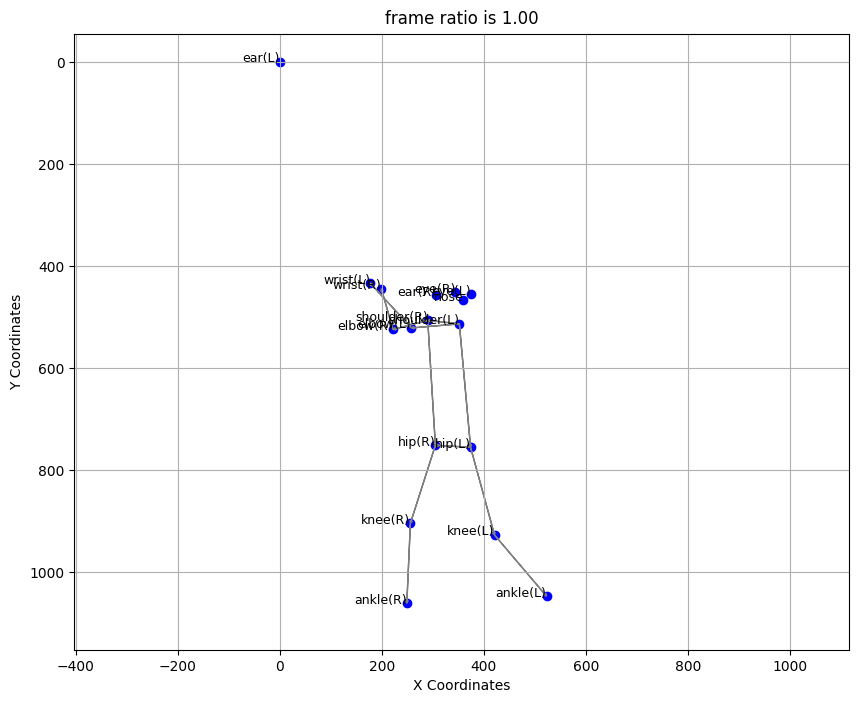

CPU times: user 1min 38s, sys: 1.83 s, total: 1min 39s
Wall time: 1min 45s


In [162]:
%%time
visualize_df(df)
mp4 = open( f'{cfg.video_name}_skelton.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="50%" height="50%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")

## 11.それぞれの部位の通過した軌跡を表示する